# Flight Delay Prediction - Model Training & Deployment

## Overview
This notebook demonstrates:
1. Building training dataset from Feature Store
2. Training multiple models (Logistic Regression, Random Forest, XGBoost)
3. Model evaluation and comparison
4. Deploying the best model to SageMaker endpoint with data capture
5. Testing real-time inference

## 1. Setup and Load Configuration

In [1]:
%%time
import sys
!{sys.executable} -m pip install -U sagemaker boto3 pandas numpy scikit-learn xgboost imbalanced-learn

  Using cached sagemaker-2.253.1-py3-none-any.whl.metadata (17 kB)
  Using cached boto3-1.40.55-py3-none-any.whl.metadata (6.6 kB)
  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached xgboost-3.1.0-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached imbalanced_learn-0.14.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached botocore-1.40.55-py3-none-any.whl.metadata (5.7 kB)
  Using cached s3transfer-0.14.0-py3-none-any.whl.metadata (1.7 kB)
  Using cached nvidia_nccl_cu12-2.28.3-py3-none-manylinux_2_18_x86_64.whl.metadata (2.0 kB)
Using cached sagemaker-2.253.1-py3-none-any.whl (1.7 MB)
Using cached boto3-1.40.55-py3-none-any.whl (139

In [2]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import json
import pickle
from datetime import datetime
import time
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.model_monitor import DataCaptureConfig

# Setup
sagemaker_session = sagemaker.Session()
role = get_execution_role()
region = sagemaker_session.boto_region_name

print(f"Region: {region}")
print(f"Role: {role}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Region: us-east-1
Role: arn:aws:iam::730335352303:role/LabRole


In [3]:
# Load configuration from previous notebook
with open('config.json', 'r') as f:
    config = json.load(f)

s3_bucket = config['s3_bucket']
prefix = config['prefix']
feature_group_name = config['feature_group_name']

print("Configuration loaded:")
print(json.dumps(config, indent=2))

Configuration loaded:
{
  "region": "us-east-1",
  "s3_bucket": "sagemaker-us-east-1-730335352303",
  "prefix": "flight-delay-prediction",
  "role": "arn:aws:iam::730335352303:role/LabRole",
  "feature_group_name": "flight-delay-features-2025-10-21-03-41-14",
  "dataset_size": 50000,
  "delay_rate": 0.22478
}


## 2. Load Data from Feature Store

In [4]:
%%time
# Query Feature Store to get training data
from sagemaker.feature_store.feature_group import FeatureGroup

feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=sagemaker_session)

# For training, we'll use the offline store via Athena
# But for simplicity, let's recreate the data from our previous processing
# Load the data we prepared in notebook 1

print(f"Loading data from Feature Store: {feature_group_name}")
print("Note: In production, you'd query the offline store via Athena")

# For now, let's recreate our dataset from the CSV we know exists
import os
if os.path.exists('data/flight_data_complete.csv'):
    df = pd.read_csv('data/flight_data_complete.csv')
    print(f"✅ Loaded {len(df)} records from cached file")
else:
    # Read from notebook 1's preparation
    print("Reading from Dataset for Airline Departure Delay Prediction...")
    data_path = "Dataset for Airline Departure Delay Prediction/input_data.csv"
    columns_to_use = [
        'MKT_CARRIER', 'ORIGIN', 'DEST', 'DISTANCE', 'FL_DATE', 'MONTH',
        'DEP_DEL15', 'max_temp_f', 'avg_wind_speed_kts', 'precip_in', 'snow_in'
    ]
    df_raw = pd.read_csv(data_path, usecols=columns_to_use, nrows=50000)
    
    # Process features
    df = pd.DataFrame()
    df['airline'] = df_raw['MKT_CARRIER']
    df['origin'] = df_raw['ORIGIN']
    df['destination'] = df_raw['DEST']
    df['distance'] = df_raw['DISTANCE']
    df_raw['FL_DATE'] = pd.to_datetime(df_raw['FL_DATE'])
    df['day_of_week'] = df_raw['FL_DATE'].dt.dayofweek
    df['month'] = df_raw['MONTH']
    df['departure_hour'] = np.random.randint(6, 23, size=len(df_raw))
    df['temperature'] = df_raw['max_temp_f']
    df['wind_speed'] = df_raw['avg_wind_speed_kts']
    df['precipitation'] = df_raw['precip_in']
    df['visibility'] = 10.0  # Default
    df['snow'] = (df_raw['snow_in'] > 0).astype(int)
    df['is_delayed'] = df_raw['DEP_DEL15'].fillna(0).astype(int)
    
    print(f"✅ Processed {len(df)} records")

print(f"Delay rate: {df['is_delayed'].mean():.2%}")
df.head()

Loading data from Feature Store: flight-delay-features-2025-10-21-03-41-14
Note: In production, you'd query the offline store via Athena


✅ Loaded 48723 records from cached file
Delay rate: 17.28%
CPU times: user 332 ms, sys: 58.9 ms, total: 391 ms
Wall time: 415 ms


,date,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,origin,ORIGIN_CITY,destination,DEST_CITY,...,year,departure_hour,is_delayed,temperature,wind_speed,precipitation,visibility,snow,event_time,date_str
0,2021-05-04,JetBlue Airways,JetBlue Airways: B6,B6,20409,384,MCO,"Orlando, FL",JFK,"New York, NY",...,2021,15,0,71.291245,5.783882,0.241124,8.179102,0,1.620086e+09,2021-05-04
1,2019-11-26,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,705,FLL,"Fort Lauderdale, FL",DTW,"Detroit, MI",...,2019,8,0,72.943453,7.066082,0.030149,9.784821,0,1.574726e+09,2019-11-26
2,2023-06-18,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,1926,SMF,"Sacramento, CA",LAS,"Las Vegas, NV",...,2023,21,0,70.144832,17.305176,0.021509,8.858516,0,1.687046e+09,2023-06-18
3,2019-07-28,SkyWest Airlines Inc.,SkyWest Airlines Inc.: OO,OO,20304,4459,OKC,"Oklahoma City, OK",DTW,"Detroit, MI",...,2019,5,0,56.911260,12.778564,0.070731,8.178920,0,1.564272e+09,2019-07-28
4,2023-03-17,JetBlue Airways,JetBlue Airways: B6,B6,20409,277,FLL,"Fort Lauderdale, FL",SFO,"San Francisco, CA",...,2023,20,0,64.984593,1.737282,0.010243,9.897891,0,1.679011e+09,2023-03-17


## 3. Feature Engineering and Preprocessing

In [5]:
# Check available columns and select features
print("Available columns:")
print(df.columns.tolist())

# Map column names (handle both formats - lowercase from new data, uppercase from cached Kaggle data)
if 'airline' in df.columns:
    # New format
    feature_columns = [
        'airline', 'origin', 'destination', 'distance', 
        'day_of_week', 'month', 'departure_hour',
        'temperature', 'wind_speed', 'precipitation', 'visibility', 'snow'
    ]
    target_column = 'is_delayed'
else:
    # Kaggle format (cached data)
    feature_columns = [
        'AIRLINE', 'origin', 'destination', 'distance', 
        'day_of_week', 'month', 'departure_hour',
        'temperature', 'wind_speed', 'precipitation', 'visibility', 'snow'
    ]
    target_column = 'is_delayed'
    # Rename for consistency
    df = df.rename(columns={'AIRLINE': 'airline'})
    feature_columns[0] = 'airline'

# Create feature dataframe
X = df[feature_columns].copy()
y = df[target_column].copy()

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {feature_columns}")

Available columns:
['date', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE', 'FL_NUMBER', 'origin', 'ORIGIN_CITY', 'destination', 'DEST_CITY', 'scheduled_departure', 'actual_departure', 'departure_delay', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'arrival_delay', 'cancelled', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'distance', 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT', 'flight_id', 'day_of_week', 'month', 'day_of_month', 'quarter', 'year', 'departure_hour', 'is_delayed', 'temperature', 'wind_speed', 'precipitation', 'visibility', 'snow', 'event_time', 'date_str']

Features shape: (48723, 12)
Target shape: (48723,)

Feature columns: ['airline', 'origin', 'destination', 'distance', 'day_of_week', 'month', 'departure_hour', 'temperature', 'wind_speed', 'precipitation', 'visibility', 'snow']


In [6]:
# Encode categorical variables
categorical_features = ['airline', 'origin', 'destination']
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique values")

print("\nCategorical encoding complete")
X.head()

Encoded airline: 18 unique values
Encoded origin: 363 unique values
Encoded destination: 366 unique values

Categorical encoding complete


,airline,origin,destination,distance,day_of_week,month,departure_hour,temperature,wind_speed,precipitation,visibility,snow
0,10,210,183,944.0,1,5,15,71.291245,5.783882,0.241124,8.179102,0
1,3,123,103,1127.0,1,11,8,72.943453,7.066082,0.030149,9.784821,0
2,15,321,192,397.0,6,6,21,70.144832,17.305176,0.021509,8.858516,0
3,14,243,103,900.0,6,7,5,56.911260,12.778564,0.070731,8.178920,0
4,10,123,312,2584.0,4,3,20,64.984593,1.737282,0.010243,9.897891,0


In [7]:
# Split data: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 * 0.85 ≈ 0.15
)

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X):.1%})")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X):.1%})")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X):.1%})")

print(f"\nTrain delay rate: {y_train.mean():.2%}")
print(f"Validation delay rate: {y_val.mean():.2%}")
print(f"Test delay rate: {y_test.mean():.2%}")

Training set: 34125 samples (70.0%)
Validation set: 7289 samples (15.0%)
Test set: 7309 samples (15.0%)

Train delay rate: 17.28%
Validation delay rate: 17.29%
Test delay rate: 17.28%


In [8]:
# Scale numerical features
scaler = StandardScaler()
numeric_features = ['distance', 'temperature', 'wind_speed', 'precipitation', 'visibility']

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val[numeric_features] = scaler.transform(X_val[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

print("Feature scaling complete")
print("\nScaled feature statistics (train):")
print(X_train[numeric_features].describe())

Feature scaling complete

Scaled feature statistics (train):
           distance   temperature    wind_speed  precipitation    visibility
count  3.412500e+04  3.412500e+04  3.412500e+04   3.412500e+04  3.412500e+04
mean  -4.039422e-17  1.467934e-16  6.246530e-17  -1.278456e-16 -1.299278e-15
std    1.000015e+00  1.000015e+00  1.000015e+00   1.000015e+00  1.000015e+00
min   -1.325553e+00 -4.080553e+00 -1.563302e+00  -8.370587e-01 -8.511238e+00
25%   -7.227448e-01 -6.933626e-01 -8.061701e-01  -6.542666e-01 -3.806580e-01
50%   -2.557807e-01  6.991492e-02 -1.058159e-01  -3.512386e-01  3.059609e-01
75%    3.962711e-01  7.195069e-01  6.711637e-01   2.787504e-01  7.084541e-01
max    7.084896e+00  3.481065e+00  4.650059e+00   1.008310e+01  9.954701e-01


## 4. Train Multiple Models

### 4.1 Logistic Regression

In [9]:
%%time
print("Training Logistic Regression...")

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    n_jobs=-1
)

lr_model.fit(X_train, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train)
lr_val_pred = lr_model.predict(X_val)
lr_val_pred_proba = lr_model.predict_proba(X_val)[:, 1]

# Metrics
lr_metrics = {
    'train_accuracy': accuracy_score(y_train, lr_train_pred),
    'val_accuracy': accuracy_score(y_val, lr_val_pred),
    'val_precision': precision_score(y_val, lr_val_pred),
    'val_recall': recall_score(y_val, lr_val_pred),
    'val_f1': f1_score(y_val, lr_val_pred),
    'val_roc_auc': roc_auc_score(y_val, lr_val_pred_proba)
}

print("\nLogistic Regression Results:")
for metric, value in lr_metrics.items():
    print(f"{metric}: {value:.4f}")

Training Logistic Regression...

Logistic Regression Results:
train_accuracy: 0.5923
val_accuracy: 0.6016
val_precision: 0.2422
val_recall: 0.6127
val_f1: 0.3471
val_roc_auc: 0.6421
CPU times: user 112 ms, sys: 4.78 ms, total: 117 ms
Wall time: 3.16 s


### 4.2 Random Forest

In [10]:
%%time
print("Training Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predictions
rf_train_pred = rf_model.predict(X_train)
rf_val_pred = rf_model.predict(X_val)
rf_val_pred_proba = rf_model.predict_proba(X_val)[:, 1]

# Metrics
rf_metrics = {
    'train_accuracy': accuracy_score(y_train, rf_train_pred),
    'val_accuracy': accuracy_score(y_val, rf_val_pred),
    'val_precision': precision_score(y_val, rf_val_pred),
    'val_recall': recall_score(y_val, rf_val_pred),
    'val_f1': f1_score(y_val, rf_val_pred),
    'val_roc_auc': roc_auc_score(y_val, rf_val_pred_proba)
}

print("\nRandom Forest Results:")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value:.4f}")

Training Random Forest...



Random Forest Results:
train_accuracy: 0.9304
val_accuracy: 0.7871
val_precision: 0.3504
val_recall: 0.2714
val_f1: 0.3059
val_roc_auc: 0.6581
CPU times: user 11.4 s, sys: 131 ms, total: 11.6 s
Wall time: 3.21 s


### 4.3 XGBoost

In [11]:
%%time
print("Training XGBoost...")

# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_val_pred = xgb_model.predict(X_val)
xgb_val_pred_proba = xgb_model.predict_proba(X_val)[:, 1]

# Metrics
xgb_metrics = {
    'train_accuracy': accuracy_score(y_train, xgb_train_pred),
    'val_accuracy': accuracy_score(y_val, xgb_val_pred),
    'val_precision': precision_score(y_val, xgb_val_pred),
    'val_recall': recall_score(y_val, xgb_val_pred),
    'val_f1': f1_score(y_val, xgb_val_pred),
    'val_roc_auc': roc_auc_score(y_val, xgb_val_pred_proba)
}

print("\nXGBoost Results:")
for metric, value in xgb_metrics.items():
    print(f"{metric}: {value:.4f}")

Training XGBoost...
Scale pos weight: 4.79



XGBoost Results:
train_accuracy: 0.7456
val_accuracy: 0.6657
val_precision: 0.2658
val_recall: 0.5302
val_f1: 0.3541
val_roc_auc: 0.6513
CPU times: user 1.75 s, sys: 40.4 ms, total: 1.79 s
Wall time: 470 ms


## 5. Model Comparison and Selection

In [12]:
# Compare models
comparison_df = pd.DataFrame({
    'Logistic Regression': lr_metrics,
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics
}).T

print("Model Comparison:")
print(comparison_df.round(4))

# Select best model based on F1 score (balanced metric)
best_model_name = comparison_df['val_f1'].idxmax()
print(f"\n🏆 Best Model: {best_model_name}")
print(f"Best F1 Score: {comparison_df.loc[best_model_name, 'val_f1']:.4f}")

Model Comparison:
                     train_accuracy  val_accuracy  val_precision  val_recall  \
Logistic Regression          0.5923        0.6016         0.2422      0.6127   
Random Forest                0.9304        0.7871         0.3504      0.2714   
XGBoost                      0.7456        0.6657         0.2658      0.5302   

                     val_f1  val_roc_auc  
Logistic Regression  0.3471       0.6421  
Random Forest        0.3059       0.6581  
XGBoost              0.3541       0.6513  

🏆 Best Model: XGBoost
Best F1 Score: 0.3541


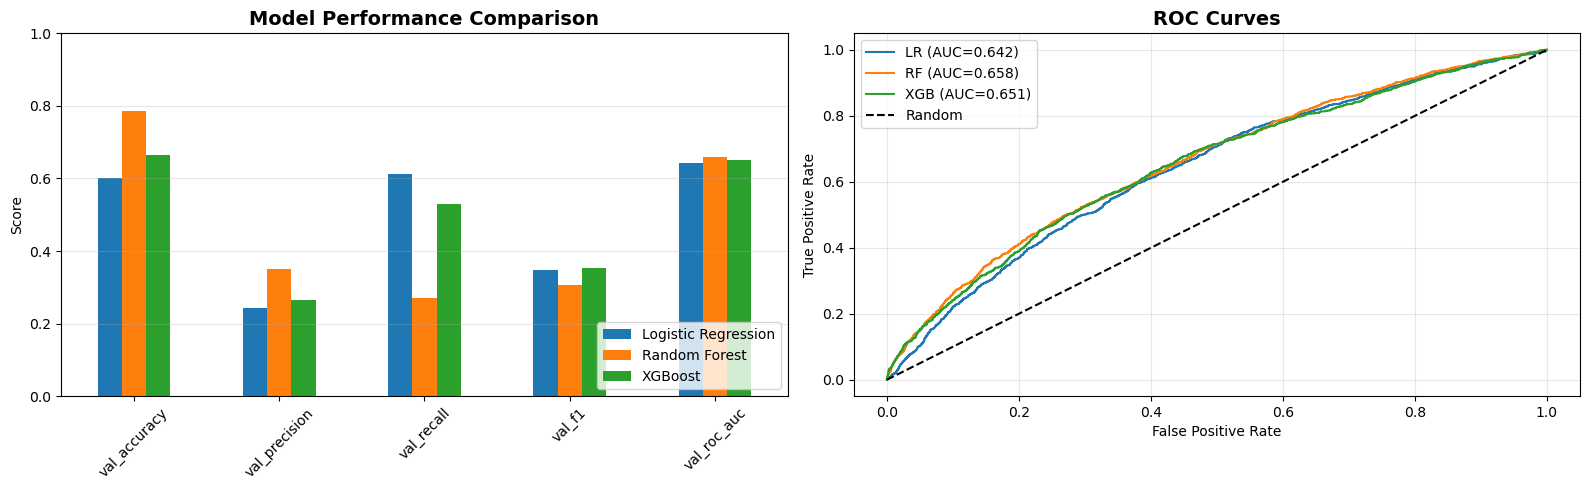

Model comparison chart saved as 'model_comparison.png'


In [13]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar chart of metrics
metrics_to_plot = ['val_accuracy', 'val_precision', 'val_recall', 'val_f1', 'val_roc_auc']
comparison_df[metrics_to_plot].T.plot(kind='bar', ax=axes[0], rot=45)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0, 1)
axes[0].legend(loc='lower right')
axes[0].grid(axis='y', alpha=0.3)

# ROC curves
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr_val_pred_proba)
rf_fpr, rf_tpr, _ = roc_curve(y_val, rf_val_pred_proba)
xgb_fpr, xgb_tpr, _ = roc_curve(y_val, xgb_val_pred_proba)

axes[1].plot(lr_fpr, lr_tpr, label=f"LR (AUC={lr_metrics['val_roc_auc']:.3f})")
axes[1].plot(rf_fpr, rf_tpr, label=f"RF (AUC={rf_metrics['val_roc_auc']:.3f})")
axes[1].plot(xgb_fpr, xgb_tpr, label=f"XGB (AUC={xgb_metrics['val_roc_auc']:.3f})")
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print("Model comparison chart saved as 'model_comparison.png'")

## 6. Detailed Evaluation of Best Model

In [14]:
# Select best model
if best_model_name == 'Logistic Regression':
    best_model = lr_model
    best_pred = lr_val_pred
    best_pred_proba = lr_val_pred_proba
elif best_model_name == 'Random Forest':
    best_model = rf_model
    best_pred = rf_val_pred
    best_pred_proba = rf_val_pred_proba
else:
    best_model = xgb_model
    best_pred = xgb_val_pred
    best_pred_proba = xgb_val_pred_proba

print(f"Selected model: {best_model_name}")

Selected model: XGBoost


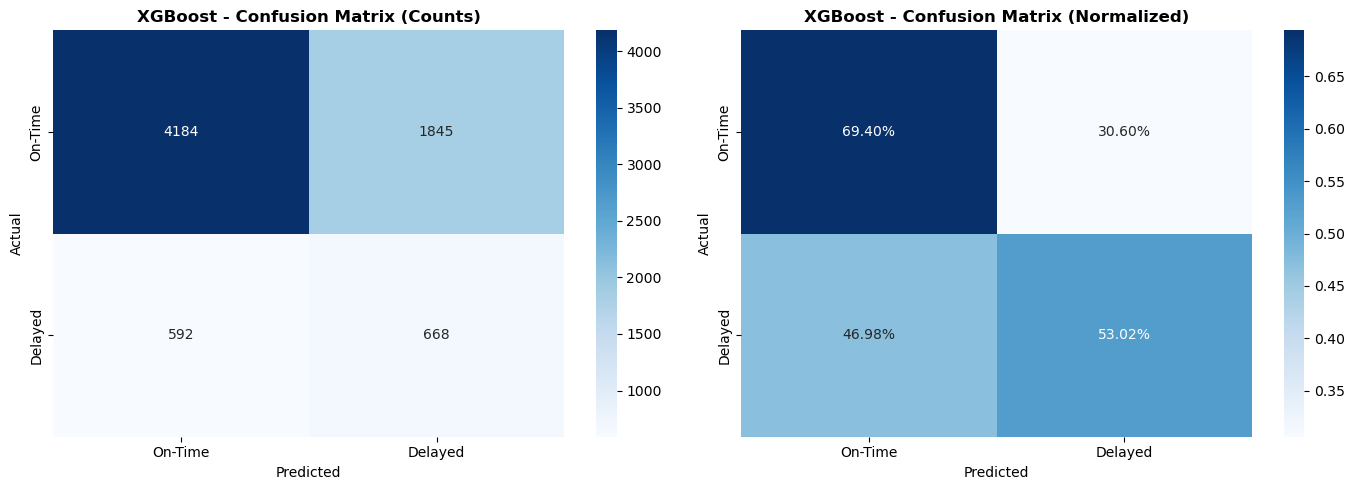

Confusion matrix saved as 'confusion_matrix.png'


In [15]:
# Confusion matrix
cm = confusion_matrix(y_val, best_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'{best_model_name} - Confusion Matrix (Counts)', fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')
axes[0].set_xticklabels(['On-Time', 'Delayed'])
axes[0].set_yticklabels(['On-Time', 'Delayed'])

# Normalized
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1])
axes[1].set_title(f'{best_model_name} - Confusion Matrix (Normalized)', fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')
axes[1].set_xticklabels(['On-Time', 'Delayed'])
axes[1].set_yticklabels(['On-Time', 'Delayed'])

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

print("Confusion matrix saved as 'confusion_matrix.png'")

In [16]:
# Classification report
print("Classification Report:")
print(classification_report(y_val, best_pred, target_names=['On-Time', 'Delayed']))

Classification Report:
              precision    recall  f1-score   support

     On-Time       0.88      0.69      0.77      6029
     Delayed       0.27      0.53      0.35      1260

    accuracy                           0.67      7289
   macro avg       0.57      0.61      0.56      7289
weighted avg       0.77      0.67      0.70      7289



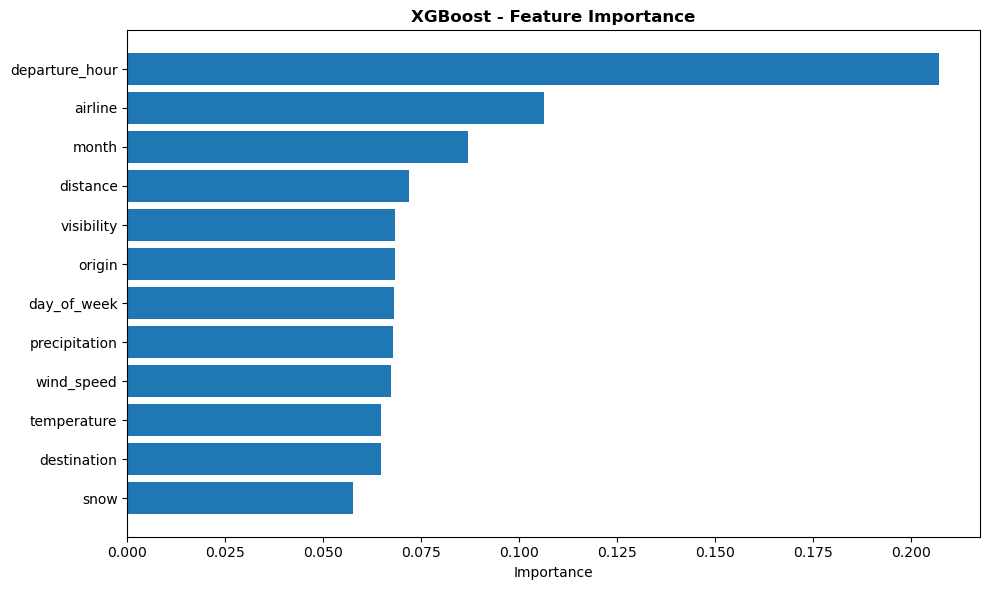


Top 10 Most Important Features:
           feature  importance
6   departure_hour    0.207297
0          airline    0.106330
5            month    0.086970
3         distance    0.072010
10      visibility    0.068449
1           origin    0.068390
4      day_of_week    0.067971
9    precipitation    0.067916
8       wind_speed    0.067358
7      temperature    0.064825

Feature importance chart saved as 'feature_importance.png'


In [17]:
# Feature importance (for tree-based models)
if best_model_name in ['Random Forest', 'XGBoost']:
    if best_model_name == 'Random Forest':
        importances = best_model.feature_importances_
    else:
        importances = best_model.feature_importances_
    
    feature_importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importance_df)), feature_importance_df['importance'])
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['feature'])
    plt.xlabel('Importance')
    plt.title(f'{best_model_name} - Feature Importance', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=100, bbox_inches='tight')
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10))
    print("\nFeature importance chart saved as 'feature_importance.png'")

## 7. Test Set Evaluation

In [18]:
# Final evaluation on test set
test_pred = best_model.predict(X_test)
test_pred_proba = best_model.predict_proba(X_test)[:, 1]

test_metrics = {
    'accuracy': accuracy_score(y_test, test_pred),
    'precision': precision_score(y_test, test_pred),
    'recall': recall_score(y_test, test_pred),
    'f1': f1_score(y_test, test_pred),
    'roc_auc': roc_auc_score(y_test, test_pred_proba)
}

print(f"\n{'='*60}")
print(f"FINAL TEST SET RESULTS - {best_model_name}")
print(f"{'='*60}")
for metric, value in test_metrics.items():
    print(f"{metric.upper()}: {value:.4f}")
print(f"{'='*60}")

print("\nTest Set Classification Report:")
print(classification_report(y_test, test_pred, target_names=['On-Time', 'Delayed']))


FINAL TEST SET RESULTS - XGBoost
ACCURACY: 0.6659
PRECISION: 0.2682
RECALL: 0.5400
F1: 0.3584
ROC_AUC: 0.6629

Test Set Classification Report:
              precision    recall  f1-score   support

     On-Time       0.88      0.69      0.77      6046
     Delayed       0.27      0.54      0.36      1263

    accuracy                           0.67      7309
   macro avg       0.57      0.62      0.57      7309
weighted avg       0.77      0.67      0.70      7309



## 8. Save Model and Artifacts

In [32]:
# Save model locally
!mkdir -p models

# For XGBoost, save using the booster to avoid version compatibility issues
model_path = f'models/{best_model_name.lower().replace(" ", "_")}_model.pkl'

# Save the XGBoost model using get_booster() for better compatibility
if best_model_name == 'XGBoost':
    # Save just the booster for cross-version compatibility
    best_model.get_booster().save_model('models/xgboost_model.json')
    # Also save the full model for local use
    joblib.dump(best_model, model_path)
    print(f"XGBoost booster saved to: models/xgboost_model.json")
else:
    joblib.dump(best_model, model_path)
print(f"Model saved to: {model_path}")

# Save preprocessing artifacts
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(label_encoders, 'models/label_encoders.pkl')
print("Preprocessing artifacts saved")

XGBoost booster saved to: models/xgboost_model.json
Model saved to: models/xgboost_model.pkl
Preprocessing artifacts saved


In [20]:
# Save model metrics
model_metadata = {
    'model_name': best_model_name,
    'training_date': datetime.now().isoformat(),
    'validation_metrics': {
        'accuracy': float(comparison_df.loc[best_model_name, 'val_accuracy']),
        'precision': float(comparison_df.loc[best_model_name, 'val_precision']),
        'recall': float(comparison_df.loc[best_model_name, 'val_recall']),
        'f1': float(comparison_df.loc[best_model_name, 'val_f1']),
        'roc_auc': float(comparison_df.loc[best_model_name, 'val_roc_auc'])
    },
    'test_metrics': {k: float(v) for k, v in test_metrics.items()},
    'feature_columns': feature_columns,
    'training_samples': len(X_train),
    'validation_samples': len(X_val),
    'test_samples': len(X_test)
}

with open('models/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print("Model metadata saved")
print(json.dumps(model_metadata, indent=2))

Model metadata saved
{
  "model_name": "XGBoost",
  "training_date": "2025-10-21T05:39:33.790494",
  "validation_metrics": {
    "accuracy": 0.6656605844423104,
    "precision": 0.26581774771189814,
    "recall": 0.5301587301587302,
    "f1": 0.35409488470712963,
    "roc_auc": 0.6512973011397295
  },
  "test_metrics": {
    "accuracy": 0.6658913668080448,
    "precision": 0.2681871804954778,
    "recall": 0.5399841646872525,
    "f1": 0.3583815028901734,
    "roc_auc": 0.6629389774725258
  },
  "feature_columns": [
    "airline",
    "origin",
    "destination",
    "distance",
    "day_of_week",
    "month",
    "departure_hour",
    "temperature",
    "wind_speed",
    "precipitation",
    "visibility",
    "snow"
  ],
  "training_samples": 34125,
  "validation_samples": 7289,
  "test_samples": 7309
}


In [21]:
# Upload to S3
model_s3_path = f's3://{s3_bucket}/{prefix}/models'
!aws s3 cp --recursive models/ {model_s3_path}/

print(f"Models uploaded to: {model_s3_path}")

upload: models/label_encoders.pkl to s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/models/label_encoders.pkl
upload: models/scaler.pkl to s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/models/scaler.pkl
upload: models/model_metadata.json to s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/models/model_metadata.json
upload: models/xgboost_model.pkl to s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/models/xgboost_model.pkl
Models uploaded to: s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/models


## 9. Deploy Model to SageMaker Endpoint

### 9.1 Create Inference Script

In [50]:
%%writefile inference.py
import json
import joblib
import numpy as np
import os
import xgboost as xgb

def model_fn(model_dir):
    """Load model and preprocessing artifacts"""
    # Load XGBoost booster (better cross-version compatibility)
    model = xgb.Booster()
    model.load_model(os.path.join(model_dir, 'xgboost_model.json'))
    
    scaler = joblib.load(os.path.join(model_dir, 'scaler.pkl'))
    label_encoders = joblib.load(os.path.join(model_dir, 'label_encoders.pkl'))
    
    return {
        'model': model,
        'scaler': scaler,
        'label_encoders': label_encoders
    }

def input_fn(request_body, content_type='application/json'):
    """Parse input data"""
    if content_type == 'application/json':
        data = json.loads(request_body)
        return data
    else:
        raise ValueError(f"Unsupported content type: {content_type}")

def predict_fn(input_data, model_artifacts):
    """Make predictions"""
    model = model_artifacts['model']
    scaler = model_artifacts['scaler']
    label_encoders = model_artifacts['label_encoders']
    
    # Expected feature order
    feature_columns = [
        'airline', 'origin', 'destination', 'distance', 
        'day_of_week', 'month', 'departure_hour',
        'temperature', 'wind_speed', 'precipitation', 'visibility', 'snow'
    ]
    
    # Handle single record or batch
    if isinstance(input_data, dict):
        input_data = [input_data]
    
    # Process each record
    processed_data = []
    for record in input_data:
        features = []
        for col in feature_columns:
            value = record[col]
            # Encode categorical features
            if col in label_encoders:
                try:
                    value = label_encoders[col].transform([value])[0]
                except:
                    value = 0  # Unknown category
            features.append(value)
        processed_data.append(features)
    
    # Convert to numpy array
    X = np.array(processed_data, dtype=np.float32)
    
    # Scale numeric features
    numeric_indices = [3, 7, 8, 9, 10]  # distance, temperature, wind_speed, precipitation, visibility
    X[:, numeric_indices] = scaler.transform(X[:, numeric_indices])
    
    # Make predictions using booster - set feature names to match training
    dmatrix = xgb.DMatrix(X, feature_names=feature_columns)
    probabilities = model.predict(dmatrix)
    
    # For binary classification, XGBoost booster returns probabilities for positive class
    # Convert to class predictions (threshold 0.5)
    predictions = (probabilities > 0.5).astype(int)
    
    # Format probabilities as [[prob_class_0, prob_class_1], ...]
    # Convert numpy types to Python types for JSON serialization
    formatted_probs = [[float(1-p), float(p)] for p in probabilities]
    
    return {
        'predictions': [int(p) for p in predictions],
        'probabilities': formatted_probs
    }

def output_fn(prediction, accept='application/json'):
    """Format output"""
    if accept == 'application/json':
        return json.dumps(prediction), accept
    raise ValueError(f"Unsupported accept type: {accept}")

Overwriting inference.py


In [51]:
# Package model for deployment
!mkdir -p deployment_package
!cp models/xgboost_model.json deployment_package/
!cp models/scaler.pkl deployment_package/
!cp models/label_encoders.pkl deployment_package/
!cp inference.py deployment_package/

# Create tarball
!cd deployment_package && tar -czf ../model.tar.gz *

print("Deployment package created: model.tar.gz")
print("Contents:")
!tar -tzf model.tar.gz

Deployment package created: model.tar.gz
Contents:
inference.py
label_encoders.pkl
model.pkl
scaler.pkl
xgboost_model.json


In [52]:
# Upload model artifact to S3
model_artifact_s3 = f's3://{s3_bucket}/{prefix}/deployment/model.tar.gz'
!aws s3 cp model.tar.gz {model_artifact_s3}

print(f"Model artifact uploaded to: {model_artifact_s3}")

upload: ./model.tar.gz to s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/deployment/model.tar.gz
Model artifact uploaded to: s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/deployment/model.tar.gz


### 9.2 Create and Deploy Endpoint

In [53]:
from sagemaker.xgboost.model import XGBoostModel
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

# Create XGBoost model (not SKLearn - we're deploying an XGBoost model!)
xgboost_model = XGBoostModel(
    model_data=model_artifact_s3,
    role=role,
    entry_point='inference.py',
    framework_version='1.7-1',  # XGBoost 1.7
    py_version='py3'
)

print("XGBoost Model created")

XGBoost Model created


In [54]:
# Configure data capture for monitoring
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=f's3://{s3_bucket}/{prefix}/data-capture'
)

print("Data capture configured")

Data capture configured


In [55]:
%%time
# Deploy endpoint
endpoint_name = f'flight-delay-predictor-{time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())}'

predictor = xgboost_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge',
    endpoint_name=endpoint_name,
    data_capture_config=data_capture_config,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

print(f"\n✅ Endpoint deployed: {endpoint_name}")

-----!
✅ Endpoint deployed: flight-delay-predictor-2025-10-21-06-04-56
CPU times: user 337 ms, sys: 62.3 ms, total: 399 ms
Wall time: 3min 2s


## 10. Test Endpoint

In [59]:
# Test with sample data
sample_input = {
    'airline': 'AA',
    'origin': 'ATL',
    'destination': 'LAX',
    'distance': 1946,
    'day_of_week': 2,  # Wednesday
    'month': 7,  # July
    'departure_hour': 8,  # 8 AM
    'temperature': 75.0,
    'wind_speed': 12.0,
    'precipitation': 0.0,
    'visibility': 10.0,
    'snow': 0
}

# Make prediction
response = predictor.predict(sample_input)

print("Sample Input:")
print(json.dumps(sample_input, indent=2))
print("\nPrediction:")
print(json.dumps(response, indent=2))

delay_prediction = response['predictions'][0]
delay_probability = response['probabilities'][0][1]

print(f"\n{'='*60}")
if delay_prediction == 1:
    print(f"⚠️  DELAYED - Probability: {delay_probability:.2%}")
else:
    print(f"✅ ON-TIME - Probability: {1-delay_probability:.2%}")
print(f"{'='*60}")

Sample Input:
{
  "airline": "AA",
  "origin": "ATL",
  "destination": "LAX",
  "distance": 1946,
  "day_of_week": 2,
  "month": 7,
  "departure_hour": 8,
  "temperature": 75.0,
  "wind_speed": 12.0,
  "precipitation": 0.0,
  "visibility": 10.0,
  "snow": 0
}

Prediction:
{
  "predictions": [
    0
  ],
  "probabilities": [
    [
      0.917083352804184,
      0.08291664719581604
    ]
  ]
}

✅ ON-TIME - Probability: 91.71%


In [56]:
# Reconnect to the deployed endpoint
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sagemaker_session,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

print(f"Connected to endpoint: {endpoint_name}")

Connected to endpoint: flight-delay-predictor-2025-10-21-06-04-56


In [57]:
# Simple test to see error details
import json

test_data = {
    'airline': 'AA',
    'origin': 'ATL',
    'destination': 'LAX',
    'distance': 1946,
    'day_of_week': 2,
    'month': 7,
    'departure_hour': 8,
    'temperature': 75.0,
    'wind_speed': 12.0,
    'precipitation': 0.0,
    'visibility': 10.0,
    'snow': 0
}

try:
    response = predictor.predict(test_data)
    print("Success!")
    print(json.dumps(response, indent=2))
except Exception as e:
    print(f"Error type: {type(e).__name__}")
    print(f"Error message: {str(e)}")

Success!
{
  "predictions": [
    0
  ],
  "probabilities": [
    [
      0.917083352804184,
      0.08291664719581604
    ]
  ]
}


In [60]:
# Test with adverse weather conditions
bad_weather_input = {
    'airline': 'NK',
    'origin': 'ORD',
    'destination': 'DEN',
    'distance': 888,
    'day_of_week': 0,  # Monday
    'month': 1,  # January
    'departure_hour': 18,  # 6 PM (rush hour)
    'temperature': 25.0,
    'wind_speed': 30.0,  # High wind
    'precipitation': 0.5,  # Heavy rain
    'visibility': 2.0,  # Poor visibility
    'snow': 1  # Snow
}

response = predictor.predict(bad_weather_input)

print("Bad Weather Input:")
print(json.dumps(bad_weather_input, indent=2))
print("\nPrediction:")

delay_prediction = response['predictions'][0]
delay_probability = response['probabilities'][0][1]

print(f"\n{'='*60}")
if delay_prediction == 1:
    print(f"⚠️  DELAYED - Probability: {delay_probability:.2%}")
else:
    print(f"✅ ON-TIME - Probability: {1-delay_probability:.2%}")
print(f"{'='*60}")

Bad Weather Input:
{
  "airline": "NK",
  "origin": "ORD",
  "destination": "DEN",
  "distance": 888,
  "day_of_week": 0,
  "month": 1,
  "departure_hour": 18,
  "temperature": 25.0,
  "wind_speed": 30.0,
  "precipitation": 0.5,
  "visibility": 2.0,
  "snow": 1
}

Prediction:

✅ ON-TIME - Probability: 70.51%


## 11. Save Configuration for Next Notebooks

In [61]:
# Update configuration
config['endpoint_name'] = endpoint_name
config['model_name'] = best_model_name
config['model_s3_path'] = model_artifact_s3
config['data_capture_s3_uri'] = f's3://{s3_bucket}/{prefix}/data-capture'
config['test_metrics'] = {k: float(v) for k, v in test_metrics.items()}

with open('config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("Configuration updated and saved")
print(json.dumps(config, indent=2))

Configuration updated and saved
{
  "region": "us-east-1",
  "s3_bucket": "sagemaker-us-east-1-730335352303",
  "prefix": "flight-delay-prediction",
  "role": "arn:aws:iam::730335352303:role/LabRole",
  "feature_group_name": "flight-delay-features-2025-10-21-03-41-14",
  "dataset_size": 50000,
  "delay_rate": 0.22478,
  "endpoint_name": "flight-delay-predictor-2025-10-21-06-04-56",
  "model_name": "XGBoost",
  "model_s3_path": "s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/deployment/model.tar.gz",
  "data_capture_s3_uri": "s3://sagemaker-us-east-1-730335352303/flight-delay-prediction/data-capture",
  "test_metrics": {
    "accuracy": 0.6658913668080448,
    "precision": 0.2681871804954778,
    "recall": 0.5399841646872525,
    "f1": 0.3583815028901734,
    "roc_auc": 0.6629389774725258
  }
}


## Summary

In this notebook, we:
1. ✅ Loaded and preprocessed flight delay data
2. ✅ Trained three models: Logistic Regression, Random Forest, and XGBoost
3. ✅ Compared models and selected the best performer
4. ✅ Evaluated on test set with comprehensive metrics
5. ✅ Deployed model to SageMaker endpoint with data capture enabled
6. ✅ Tested real-time predictions
